In [0]:
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import pandas as pd
import numpy as np
from time import time
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# WINDOW_SIZE = 257, CODEBOOK_SIZE = 10000

enable_norm = True

X_train = np.loadtxt("feature_train.csv", delimiter = ",").reshape(-1,384)
y_train = np.loadtxt("label_train.csv", delimiter = ",")
X_test = np.loadtxt("feature_test.csv", delimiter=",").reshape(-1,384)
y_test = np.loadtxt("label_test.csv", delimiter=",")


In [0]:
if enable_norm:
    X_train = np.transpose(X_train)
    X_test = np.transpose(X_test)

    model_normalizer_horizontal = MinMaxScaler()
    model_normalizer_horizontal.fit(X_train)
    X_train = model_normalizer_horizontal.transform(X_train)

    model_normalizer_horizontal = MinMaxScaler()
    model_normalizer_horizontal.fit(X_test)
    X_test = model_normalizer_horizontal.transform(X_test)

    X_train = np.transpose(X_train)
    X_test = np.transpose(X_test)

    model_normalizer_vertical = MinMaxScaler()
    model_normalizer_vertical.fit(X_train)

    X_train = model_normalizer_vertical.transform(X_train)
    X_test = model_normalizer_vertical.transform(X_test)

In [0]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

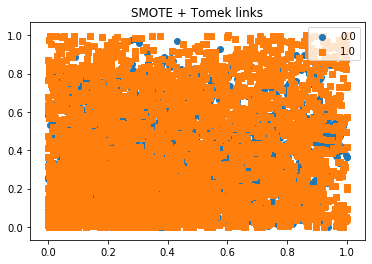

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


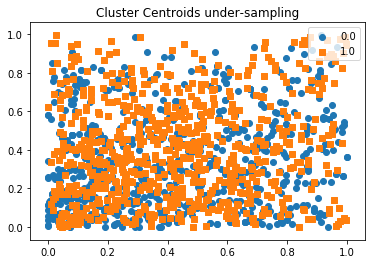

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


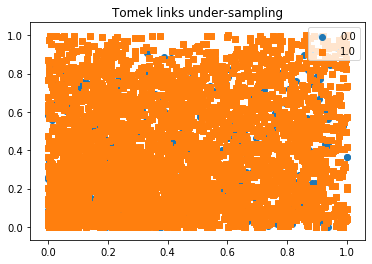

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


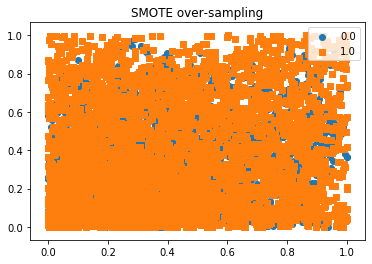

In [0]:
import imblearn

from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='auto')
X_smt, y_smt = smt.fit_sample(X_train, y_train)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')


from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(sampling_strategy='auto')
X_cc, y_cc = cc.fit_sample(X_train, y_train)

plot_2d_space(X_cc, y_cc, 'Cluster Centroids under-sampling')

from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_sample(X_train, y_train)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

In [0]:
X_train, y_train = X_smt, y_smt
X_test, y_test = smt.fit_sample(X_test, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
label_names = ['Buggy', 'Correct']

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

-> Processing 10-Fold Cross Validation and Grid Search

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1770s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0480s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0686s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 185 tasks      | elapsed:  

-> Done! Show Grid scores

{'mean_fit_time': array([0.00970151, 0.10341761, 0.00739734, 0.12292538, 0.00770481,
       0.22538097, 0.00722451, 0.6578861 , 0.00775149, 0.81817529,
       0.00801425, 0.82769535, 0.0076344 , 0.8106457 , 0.00757887,
       0.80343571, 0.00792568, 0.80465999, 0.00799422, 0.76120124]), 'std_fit_time': array([3.13515396e-03, 1.35316278e-02, 7.31941435e-04, 5.87912920e-03,
       9.85929667e-04, 8.93362720e-02, 4.67608552e-04, 1.19649654e-01,
       1.43497809e-03, 2.57061725e-02, 1.44609560e-03, 2.19144358e-02,
       6.31049960e-04, 1.76886284e-02, 8.05125421e-05, 2.73306484e-02,
       2.73665940e-04, 2.28083332e-02, 9.77139614e-04, 1.18838525e-01]), 'mean_score_time': array([0.        , 0.00266738, 0.        , 0.0030134 , 0.        ,
       0.00280545, 0.        , 0.00258598, 0.        , 0.00280755,
       0.        , 0.00268979, 0.        , 0.00290983, 0.        ,
       0.00257432, 0.        , 0.00282619, 0.        , 0.00224314]), 'std_score_time': array

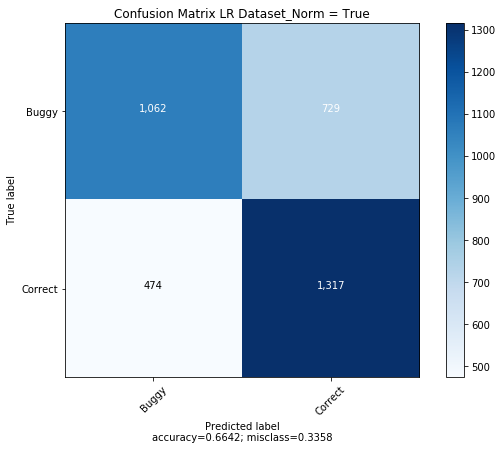

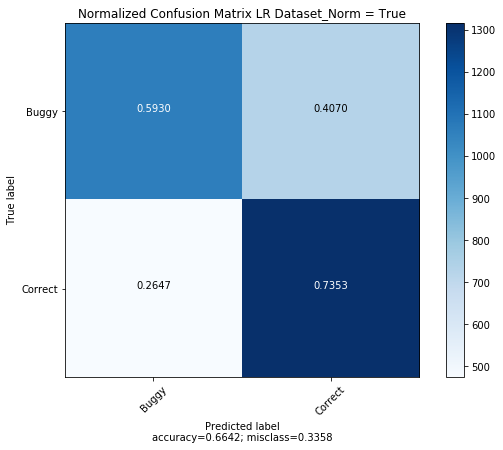




              precision    recall  f1-score   support

         0.0       0.69      0.59      0.64      1791
         1.0       0.64      0.74      0.69      1791

    accuracy                           0.66      3582
   macro avg       0.67      0.66      0.66      3582
weighted avg       0.67      0.66      0.66      3582


Accuracy 0.6641541038525963
Training time : 16.504

Test time : 0.002




In [0]:
# LR
param_grid_ = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], "penalty":["l1","l2"]}
print('-> Processing 10-Fold Cross Validation and Grid Search\n')

bow_search = GridSearchCV(LogisticRegression(), cv=10, param_grid=param_grid_, scoring='f1_micro', n_jobs=-1, verbose=10)
t0 = time()
bow_search.fit(X_train, y_train)
training_time = round(time()-t0, 3)
print('-> Done! Show Grid scores\n')

print(bow_search.cv_results_,'\n\n')

print("Best parameters set found on development set:\n")
print(bow_search.best_params_,'\n')
print("Grid scores on development set:\n")
means = bow_search.cv_results_['mean_test_score']
stds = bow_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, bow_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('\n\n')
print("Detailed classification report:\n")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.\n\n")
t0 = time()
y_true, y_pred = y_test, bow_search.predict(X_test)
test_time = round(time()-t0, 3)
cmat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm           = cmat, 
                      normalize    = False,
                      target_names = label_names,
                      cmap = plt.get_cmap('Blues'),
                      title        = "Confusion Matrix LR Dataset_Norm = %s" % str(enable_norm))
plot_confusion_matrix(cm           = cmat, 
                      target_names = label_names,
                      cmap = plt.get_cmap('Blues'),
                      title        = "Normalized Confusion Matrix LR Dataset_Norm = %s" % str(enable_norm))
print('\n\n')
print(classification_report(y_true, y_pred))
print()
print('Accuracy', metrics.accuracy_score(y_pred,y_test))
print("Training time : {}\n".format(training_time))
print("Test time : {}\n".format(test_time))
print()

In [0]:
# NB
parameters = {'alpha': (1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000)}
bow_search = GridSearchCV(MultinomialNB(), parameters, cv=10, scoring='f1_micro', n_jobs=-1, verbose=10)
t0 = time()
bow_search.fit(X_train, y_train)
training_time = round(time()-t0, 3)
print('-> Done! Show Grid scores\n')

print(bow_search.cv_results_,'\n\n')

print("Best parameters set found on development set:\n")
print(bow_search.best_params_,'\n')
print("Grid scores on development set:\n")
means = bow_search.cv_results_['mean_test_score']
stds = bow_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, bow_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('\n\n')
print("Detailed classification report:\n")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.\n\n")
t0 = time()
y_true, y_pred = y_test, bow_search.predict(X_test)
test_time = round(time()-t0, 3)
print(confusion_matrix(y_true, y_pred))
print('\n\n')
print(classification_report(y_true, y_pred))
print()
print('Accuracy', metrics.accuracy_score(y_pred,y_test))
print("Training time : {}\n".format(training_time))
print("Test time : {}\n".format(test_time))
print()

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0474s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0946s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1772s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s


-> Done! Show Grid scores

{'mean_fit_time': array([0.02445605, 0.02492232, 0.02407684, 0.02637377, 0.02634141,
       0.02493455, 0.02451622, 0.0265619 , 0.02384496, 0.02455251]), 'std_fit_time': array([0.00111774, 0.00283348, 0.00142493, 0.00681521, 0.01021695,
       0.00159459, 0.00221587, 0.00544922, 0.00118822, 0.00160942]), 'mean_score_time': array([0.00290055, 0.00268505, 0.00292315, 0.00325935, 0.00279429,
       0.00294187, 0.00348272, 0.00340931, 0.0031044 , 0.00271873]), 'std_score_time': array([0.00020963, 0.00028833, 0.00033183, 0.00054195, 0.00027658,
       0.00038677, 0.00145573, 0.00090721, 0.00058507, 0.00021018]), 'param_alpha': masked_array(data=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                   1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 1e-06}, {'alpha': 1e-05}, {'alpha': 0.0001}, {'alpha': 0.001}, {'a

[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


In [0]:
# SGD
param_grid_ = [
  {'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01]} ]
bow_search = GridSearchCV(SGDClassifier(max_iter=2), cv=10, param_grid=param_grid_, scoring='f1_micro', n_jobs=-1, verbose=10)
t0 = time()
bow_search.fit(X_train, y_train)
training_time = round(time()-t0, 3)
print('-> Done! Show Grid scores\n')

print(bow_search.cv_results_,'\n\n')

print("Best parameters set found on development set:\n")
print(bow_search.best_params_,'\n')
print("Grid scores on development set:\n")
means = bow_search.cv_results_['mean_test_score']
stds = bow_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, bow_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('\n\n')
print("Detailed classification report:\n")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.\n\n")
t0 = time()
y_true, y_pred = y_test, bow_search.predict(X_test)
test_time = round(time()-t0, 3)
print(confusion_matrix(y_true, y_pred))
print('\n\n')
print(classification_report(y_true, y_pred))
print()
print('Accuracy', metrics.accuracy_score(y_pred,y_test))
print("Training time : {}\n".format(training_time))
print("Test time : {}\n".format(test_time))
print()

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1863s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1254s.) Setting batch_size=4.


-> Done! Show Grid scores

{'mean_fit_time': array([0.03514259, 0.0334085 , 0.03412645, 0.0347358 , 0.035304  ,
       0.03493319]), 'std_fit_time': array([0.00261088, 0.00103584, 0.00270899, 0.00268961, 0.00250967,
       0.00416244]), 'mean_score_time': array([0.00250459, 0.00244806, 0.00287926, 0.00259347, 0.00257246,
       0.00244145]), 'std_score_time': array([0.00034859, 0.00037241, 0.00077994, 0.0004292 , 0.00026169,
       0.00045775]), 'param_alpha': masked_array(data=[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 1e-07}, {'alpha': 1e-06}, {'alpha': 1e-05}, {'alpha': 0.0001}, {'alpha': 0.001}, {'alpha': 0.01}], 'split0_test_score': array([0.66148325, 0.6507177 , 0.6638756 , 0.67344498, 0.65191388,
       0.67583732]), 'split1_test_score': array([0.55861244, 0.59688995, 0.69736842, 0.6423445 , 0.68181818,
       0.67105263]), 'split2_test_score': ar

[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    1.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [0]:
# RF
param_grid_ = {"min_samples_leaf": [2, 3, 5, 7, 10, 100, 250, 500, 1000]}
bow_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid_, cv=10, scoring='f1_micro', n_jobs=-1, verbose=10)
t0 = time()
bow_search.fit(X_train, y_train)
training_time = round(time()-t0, 3)
print('-> Done! Show Grid scores\n')

print(bow_search.cv_results_,'\n\n')

print("Best parameters set found on development set:\n")
print(bow_search.best_params_,'\n')
print("Grid scores on development set:\n")
means = bow_search.cv_results_['mean_test_score']
stds = bow_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, bow_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('\n\n')
print("Detailed classification report:\n")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.\n\n")
t0 = time()
y_true, y_pred = y_test, bow_search.predict(X_test)
test_time = round(time()-t0, 3)
print(confusion_matrix(y_true, y_pred))
print('\n\n')
print(classification_report(y_true, y_pred))
print()
print('Accuracy', metrics.accuracy_score(y_pred,y_test))
print("Training time : {}\n".format(training_time))
print("Test time : {}\n".format(test_time))
print()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.9min finished


-> Done! Show Grid scores

{'mean_fit_time': array([31.63315303, 29.75257235, 26.51179025, 24.85230689, 22.94121006,
       12.39908831,  8.73864338,  5.90261509,  3.16497822]), 'std_fit_time': array([1.30041267, 1.14049334, 0.96766729, 0.73346946, 0.58931412,
       0.16161533, 0.08785348, 0.06825532, 0.22543773]), 'mean_score_time': array([0.03890162, 0.03689461, 0.03631613, 0.03659215, 0.03450456,
       0.02753959, 0.02518654, 0.02330656, 0.01924083]), 'std_score_time': array([0.00425036, 0.00147186, 0.00133486, 0.00236429, 0.00169369,
       0.0006093 , 0.00037138, 0.00042939, 0.00545219]), 'param_min_samples_leaf': masked_array(data=[2, 3, 5, 7, 10, 100, 250, 500, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'min_samples_leaf': 2}, {'min_samples_leaf': 3}, {'min_samples_leaf': 5}, {'min_samples_leaf': 7}, {'min_samples_leaf': 10}, {'min_samples_leaf': 100}

In [0]:
# DT
param_grid_ = {"min_samples_leaf": [2, 3, 5, 7, 10, 100, 250, 500, 1000]}
bow_search = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid_, cv=10, scoring='f1_micro', n_jobs=-1, verbose=10)
t0 = time()
bow_search.fit(X_train, y_train)
training_time = round(time()-t0, 3)
print('-> Done! Show Grid scores\n')

print(bow_search.cv_results_,'\n\n')

print("Best parameters set found on development set:\n")
print(bow_search.best_params_,'\n')
print("Grid scores on development set:\n")
means = bow_search.cv_results_['mean_test_score']
stds = bow_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, bow_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('\n\n')
print("Detailed classification report:\n")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.\n\n")
t0 = time()
y_true, y_pred = y_test, bow_search.predict(X_test)
test_time = round(time()-t0, 3)
print(confusion_matrix(y_true, y_pred))
print('\n\n')
print(classification_report(y_true, y_pred))
print()
print('Accuracy', metrics.accuracy_score(y_pred,y_test))
print("Training time : {}\n".format(training_time))
print("Test time : {}\n".format(test_time))
print()

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.2min finished


-> Done! Show Grid scores

{'mean_fit_time': array([15.57082009, 14.79746933, 13.15020945, 12.01040297, 10.30783112,
        4.8355984 ,  3.21437464,  2.22624552,  1.44381418]), 'std_fit_time': array([1.06828142, 1.13978298, 1.18580757, 1.01151431, 0.74020689,
       0.22043072, 0.24257331, 0.13209135, 0.09246074]), 'mean_score_time': array([0.00341196, 0.00300024, 0.00300915, 0.0030174 , 0.0029664 ,
       0.00285349, 0.00283763, 0.00287492, 0.00269358]), 'std_score_time': array([8.80931103e-04, 1.22525785e-04, 1.85292810e-04, 1.03222880e-04,
       1.80321190e-04, 7.12827056e-05, 1.00024846e-04, 1.53774034e-04,
       3.76163731e-04]), 'param_min_samples_leaf': masked_array(data=[2, 3, 5, 7, 10, 100, 250, 500, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'min_samples_leaf': 2}, {'min_samples_leaf': 3}, {'min_samples_leaf': 5}, {'min_samples_leaf': 7}, {'min_sa

In [0]:
# KNN
param_grid_ = {'n_neighbors': [1], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
bow_search = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid_, cv=10, scoring='f1_micro', n_jobs=-1, verbose=10)
t0 = time()
bow_search.fit(X_train, y_train)
training_time = round(time()-t0, 3)
print('-> Done! Show Grid scores\n')

print(bow_search.cv_results_,'\n\n')

print("Best parameters set found on development set:\n")
print(bow_search.best_params_,'\n')
print("Grid scores on development set:\n")
means = bow_search.cv_results_['mean_test_score']
stds = bow_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, bow_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print('\n\n')
print("Detailed classification report:\n")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.\n\n")
t0 = time()
y_true, y_pred = y_test, bow_search.predict(X_test)
test_time = round(time()-t0, 3)
print(confusion_matrix(y_true, y_pred))
print('\n\n')
print(classification_report(y_true, y_pred))
print()
print('Accuracy', metrics.accuracy_score(y_pred,y_test))
print("Training time : {}\n".format(training_time))
print("Test time : {}\n".format(test_time))
print()

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:   50.9s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   51.3s finished


-> Done! Show Grid scores

{'mean_fit_time': array([0.4353477 , 0.44482269, 0.44627945, 0.44607458]), 'std_fit_time': array([0.01273335, 0.00742813, 0.00509626, 0.00647333]), 'mean_score_time': array([4.16724133, 4.09559412, 5.17056024, 5.11424963]), 'std_score_time': array([0.27274827, 0.28251431, 0.34107506, 0.3296678 ]), 'param_metric': masked_array(data=['euclidean', 'euclidean', 'manhattan', 'manhattan'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_neighbors': masked_array(data=[1, 1, 1, 1],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}, {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}, {'metric': 'ma